Haleluya Getachew |
Last Updated: 11/19/20 4:23PM                                                                    

# Strategy

### What Is The End Goal? 
>* Use 911 call data to find the predictors of crime severity among different neighborhoods in Baltimore City,MD.
>* Apply several preprocessing techniques. 
>* Employ + compare several machine learning models. Build a pipeline that produces accurate metrics. 
>* Integrate Kepler.gl to visualize the distribution on a map. 

### Exploratory Data Analysis 
>* Basic Insights
>* Checking distrtibutions with straightforward visualizations

### Machine Learning Model: Classification w/ Logistic Regression

***

# Importing Libraries

In [328]:
import pandas as pd
import numpy as np
import re
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_columns', None)

# Maintaining Active Token Session on Private Repo

In [338]:
# Since this repository is private, pulling the main csv file by copying and pasting its raw link will eventually cause an error.
# The error occurs when the token ID in the raw url link expires. Here is how to keep it active: 

username = 'hgetac1'
token = '6f13a588d20878f6a4d3a541f16b463ddbb5b31b'


# creates re-usable session object to access url links for raw csv files
github_session = requests.Session()
github_session.auth = (username, token)

call_data = "https://media.githubusercontent.com/media/Baltimore-Data-Science-Corps-TU-Team/Logistic-Regression-911-Calls/main/cleaned_data/911_data.csv?token=AJZB73M4M22Q3BBDC7HNRN27W3YIY"

# retrieves raw version of csv file on GitHub
path = github_session.get(call_data).content


# reads downloaded content and transforms it into pandas dataframe
call_data = pd.read_csv(StringIO(path.decode('utf-8')), low_memory=False)

# drops extra index column 
call_data = call_data.drop(columns=['Unnamed: 0'])


**NOTE**: If you get an **EmptyDataError** when running the above cell - follow these steps:

1. Go to "Logistic-Regression-911-Calls" Github Repo

2. Go to cleaned_data folder and click on **911_data.csv**

3. Click view raw

4. Copy and paste the entire url. Place that new link inside the double quotes of call_data = " "

# Looking at "Clean Data"

In [339]:
call_data.head(5)

,RecordID,CallNumber,CallDate,CallTime,DayOfWeek,Covid-19,Priority,Severity,District,Description,IncidentLocation,ZipCode,Neighborhood,PoliceDistrict,PolicePost,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,Census_Tracts,VRIZones,Location,Latitude,Longitude
0,3953549,P151262297,5/6/15,6:22:00 PM,Wednesday,Precovid,Medium,Nonviolent,NW,ARSON,2800 DENISON ST,21216.0,Hanlon-Longwood,Northwestern,641.0,7.0,D9,Greater Mondawmin,Census Tract 1507.01,NaN,"2800 DENISON ST\rBALTIMORE, MD\r(39.319911, -7...",39.319911,-76.674740
1,3845555,P151630190,6/12/15,1:36:00 AM,Friday,Precovid,Low,Nonviolent,WD,ARSON,W NORTH AV/RETREAT ST,21217.0,Penn North,Western,733.0,7.0,D9,Greater Mondawmin,Census Tract 1501,Western,"W NORTH AV\rBALTIMORE, MD",NaN,NaN
2,3788155,P151810834,6/30/15,9:13:00 AM,Tuesday,Precovid,High,Nonviolent,WD,ARSON,1900 HARLEM AV,21217.0,Midtown-Edmondson,Western,722.0,9.0,D8,Sandtown-Winchester/Harlem Park,Census Tract 1604,NaN,"1900 HARLEM AV\rBALTIMORE, MD\r(39.296311, -76...",39.296311,-76.647506
3,3659533,P152212663,8/9/15,8:20:00 PM,Sunday,Precovid,Low,Nonviolent,SE,ARSON,300 BLK N ELLWOOD AV,21224.0,Ellwood Park/Monument,Southeastern,224.0,13.0,D5,Patterson Park North & East,Census Tract 601,NaN,"300 BLK N ELLWOOD AV\rBALTIMORE, MD\r(39.29555...",39.295552,-76.573545
4,3289892,P153443369,12/10/15,10:36:00 PM,Thursday,Precovid,High,Nonviolent,SE,ARSON,E FAYETTE ST/N BROADWAY,21231.0,Washington Hill,Southeastern,212.0,12.0,D7,Oldtown/Middle East,Census Tract 301,NaN,"E N FAYETTE ST\rBALTIMORE, MD",NaN,NaN


***
**The above dataframe will undergo one hot encoding later on.**

The following categorical variables will be transformed into quantitative values to keep the machine learning algorithms (to be used later) happy . . .

***
*Why were these two attributes **not included** in the Potential Predictors list?*
* `Description`: The target feature (i.e `Severity`) was derived by looking at this attribute and labeling whether the type of `Description` best matched a nonviolent or a violent type of crime. In other words `Severity` **did not exist in the orginal dataset** and its column values (nonviolent vs. violent) were manually set up. 
    
        - If Description was used to predict Severity, the machine learning models would spit out a perfect 
          correlation. No real machine learning would actually be used because we already did the classfcation 
          work ourselves . . .
***
* `Covid-19`: Indicates whether the 911 call happened before or after 3/13/20 (the day the first Covid case was discovered in Baltimore.) The data dates back to 2015, so using this attribute as a predictor may cause **misleading results since the distribution is imbalanced**. 

         - Clearly, more 911 calls occured in the span of years prior to Covid-19.

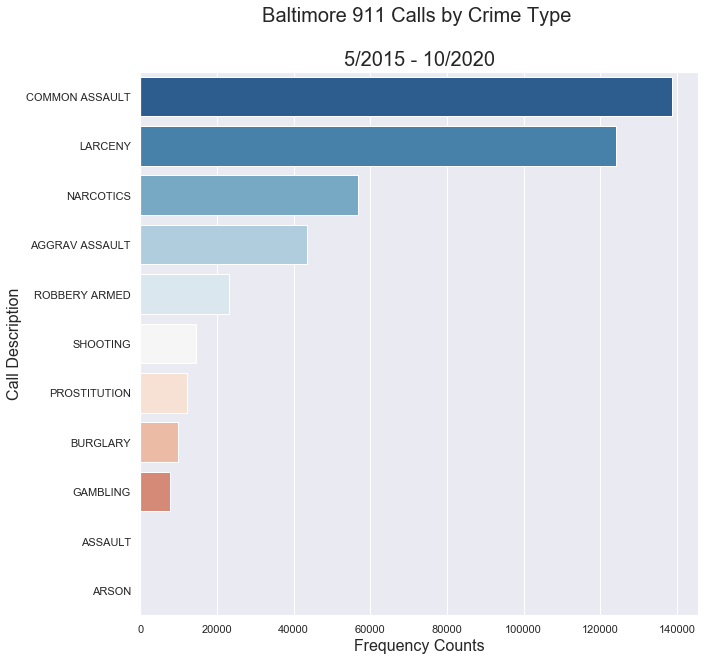

In [340]:
# Baltimore Crime Calls By Type
sns.set(style="darkgrid")
plt.figure(figsize=(10,10))
sns.countplot(y="Description", data=call_data,palette="RdBu_r", order = call_data['Description'].value_counts().index)
plt.xlabel("Frequency Counts", fontsize=16)
plt.ylabel("Call Description", fontsize=16)
plt.title("Baltimore 911 Calls by Crime Type \n\n5/2015 - 10/2020", fontsize=20) 
plt.show()

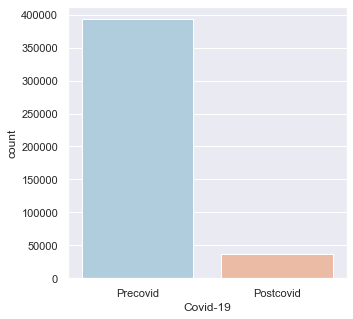

In [341]:
sns.set(style="darkgrid")
plt.figure(figsize=(5,5))
sns.countplot(x="Covid-19", data=call_data,palette="RdBu_r", order = call_data['Covid-19'].value_counts().index)

***
# Basic Insights. 

#### Descriptive Statistics

In [342]:
call_data.describe(include = "all")

,RecordID,CallNumber,CallDate,CallTime,DayOfWeek,Covid-19,Priority,Severity,District,Description,IncidentLocation,ZipCode,Neighborhood,PoliceDistrict,PolicePost,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,Census_Tracts,VRIZones,Location,Latitude,Longitude
count,4.302550e+05,430255,430255,430255,430255,430090,430255,430255,430255,430255,430255,401337.000000,429512,429433,429442.000000,429549.000000,429544,429266,429492,67618,428467,328249.000000,328249.000000
unique,NaN,429954,2677,1440,7,2,4,2,15,11,37126,NaN,278,9,NaN,NaN,10,56,200,8,31651,NaN,NaN
top,NaN,P200812953,4/30/19,4:07:00 PM,Tuesday,Precovid,Medium,Violent,NE,COMMON ASSAULT,1600 PENNSYLVANIA AV,NaN,Downtown,Central,NaN,NaN,D7,Southwest Baltimore,Census Tract 401,Tri-District,"1600 PENNSYLVANIA AV\rBALTIMORE, MD\r(39.30317...",NaN,NaN
freq,NaN,2,499,564,63018,392769,189804,229702,54837,138691,1335,NaN,16512,55580,NaN,NaN,83632,25525,19217,14842,1295,NaN,NaN
mean,3.815705e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21217.318299,NaN,NaN,521.434930,8.229799,NaN,NaN,NaN,NaN,NaN,39.298822,-76.723858
std,2.716543e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.293790,NaN,NaN,268.636565,3.795581,NaN,NaN,NaN,NaN,NaN,0.260314,1.458017
min,3.600000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21201.000000,NaN,NaN,111.000000,1.000000,NaN,NaN,NaN,NaN,NaN,26.610151,-123.300533
25%,1.289484e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21212.000000,NaN,NaN,243.000000,6.000000,NaN,NaN,NaN,NaN,NaN,39.287236,-76.654586
50%,3.286313e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21217.000000,NaN,NaN,514.000000,9.000000,NaN,NaN,NaN,NaN,NaN,39.303718,-76.619434
75%,6.480984e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21224.000000,NaN,NaN,742.000000,11.000000,NaN,NaN,NaN,NaN,NaN,39.326252,-76.590042


#### According to this dataset . . .


* **278** neighborhoods and **56** CSAs in Baltimore.
* A 911 call at **4:07:00 PM** happens most often. 
* **429,954** distinct 911 calls occured between **5/6/15 - 10/22/20**	
* **Common Assault** is the crime that gets called in most frequently. It appears **138,691** times in the dataset. 
* **Tuesday** is the most popular day for a 911 call. 
* **Central** is the police district where 911 calls come from most frquently. 

In [7]:
call_data["DayOfWeek "].value_counts()

Tuesday      63018
Friday       62857
Monday       62609
Wednesday    62594
Thursday     61352
Saturday     61133
Sunday       56692
Name: DayOfWeek , dtype: int64

In [8]:
call_data["IncidentLocation"].value_counts()

1600 PENNSYLVANIA AV      1335
1800 PENNSYLVANIA AV      1296
200                       1278
6800 REISTERSTOWN RD      1026
6600 REISTERSTOWN RD      1010
                          ... 
1700-BLK BRADDISH AV         1
2300 REISTERSTOWN            1
3200 BLK BURLEITH AV         1
MCELDERRY ST/N EAST AV       1
700 BLK W REDWOOD ST         1
Name: IncidentLocation, Length: 37126, dtype: int64

In [9]:
call_data["Neighborhood"].value_counts()

Downtown                   16512
Brooklyn                   11296
Belair-Edison              10446
Sandtown-Winchester         8720
Upton                       8541
                           ...  
Morgan Park                   34
Bellona-Gittings              23
Mt Pleasant Park              22
Blythewood                     7
Dundalk Marine Terminal        6
Name: Neighborhood, Length: 278, dtype: int64

In [10]:
call_data["Severity"].value_counts()

Violent       229702
Nonviolent    200553
Name: Severity, dtype: int64

In [11]:
call_data["Community_Statistical_Areas"].value_counts()

Southwest Baltimore                      25525
Downtown/Seton Hill                      23565
Upton/Druid Heights                      16388
Brooklyn/Curtis Bay/Hawkins Point        16304
Greater Rosemont                         15138
Sandtown-Winchester/Harlem Park          14393
Greater Charles Village/Barclay          14277
Oldtown/Middle East                      11559
Glen-Fallstaff                           11527
Cedonia/Frankford                        11284
Belair-Edison                            11117
Greater Mondawmin                        10558
Orangeville/East Highlandtown            10129
Midtown                                  10077
Pimlico/Arlington/Hilltop                 9879
Allendale/Irvington/S. Hilton             9578
Washington Village/Pigtown                9254
Southeastern                              8838
Patterson Park North & East               8784
Madison/East End                          8318
Clifton-Berea                             8121
Midway/Coldst

In [12]:
call_data['Description'].value_counts()

COMMON ASSAULT    138691
LARCENY           124113
NARCOTICS          56693
AGGRAV ASSAULT     43512
ROBBERY ARMED      23183
SHOOTING           14449
PROSTITUTION       12057
BURGLARY            9848
GAMBLING            7671
ASSAULT               19
ARSON                 19
Name: Description, dtype: int64

***
#### Checking Distributions.

* Can our potential predictors list be narrowed down?  
* **Recall the list**: DayOfWeek, Neighborhoood, PoliceDistrict, Community_Statistical_Areas, CallTime, ZipCode, PolicePost, 

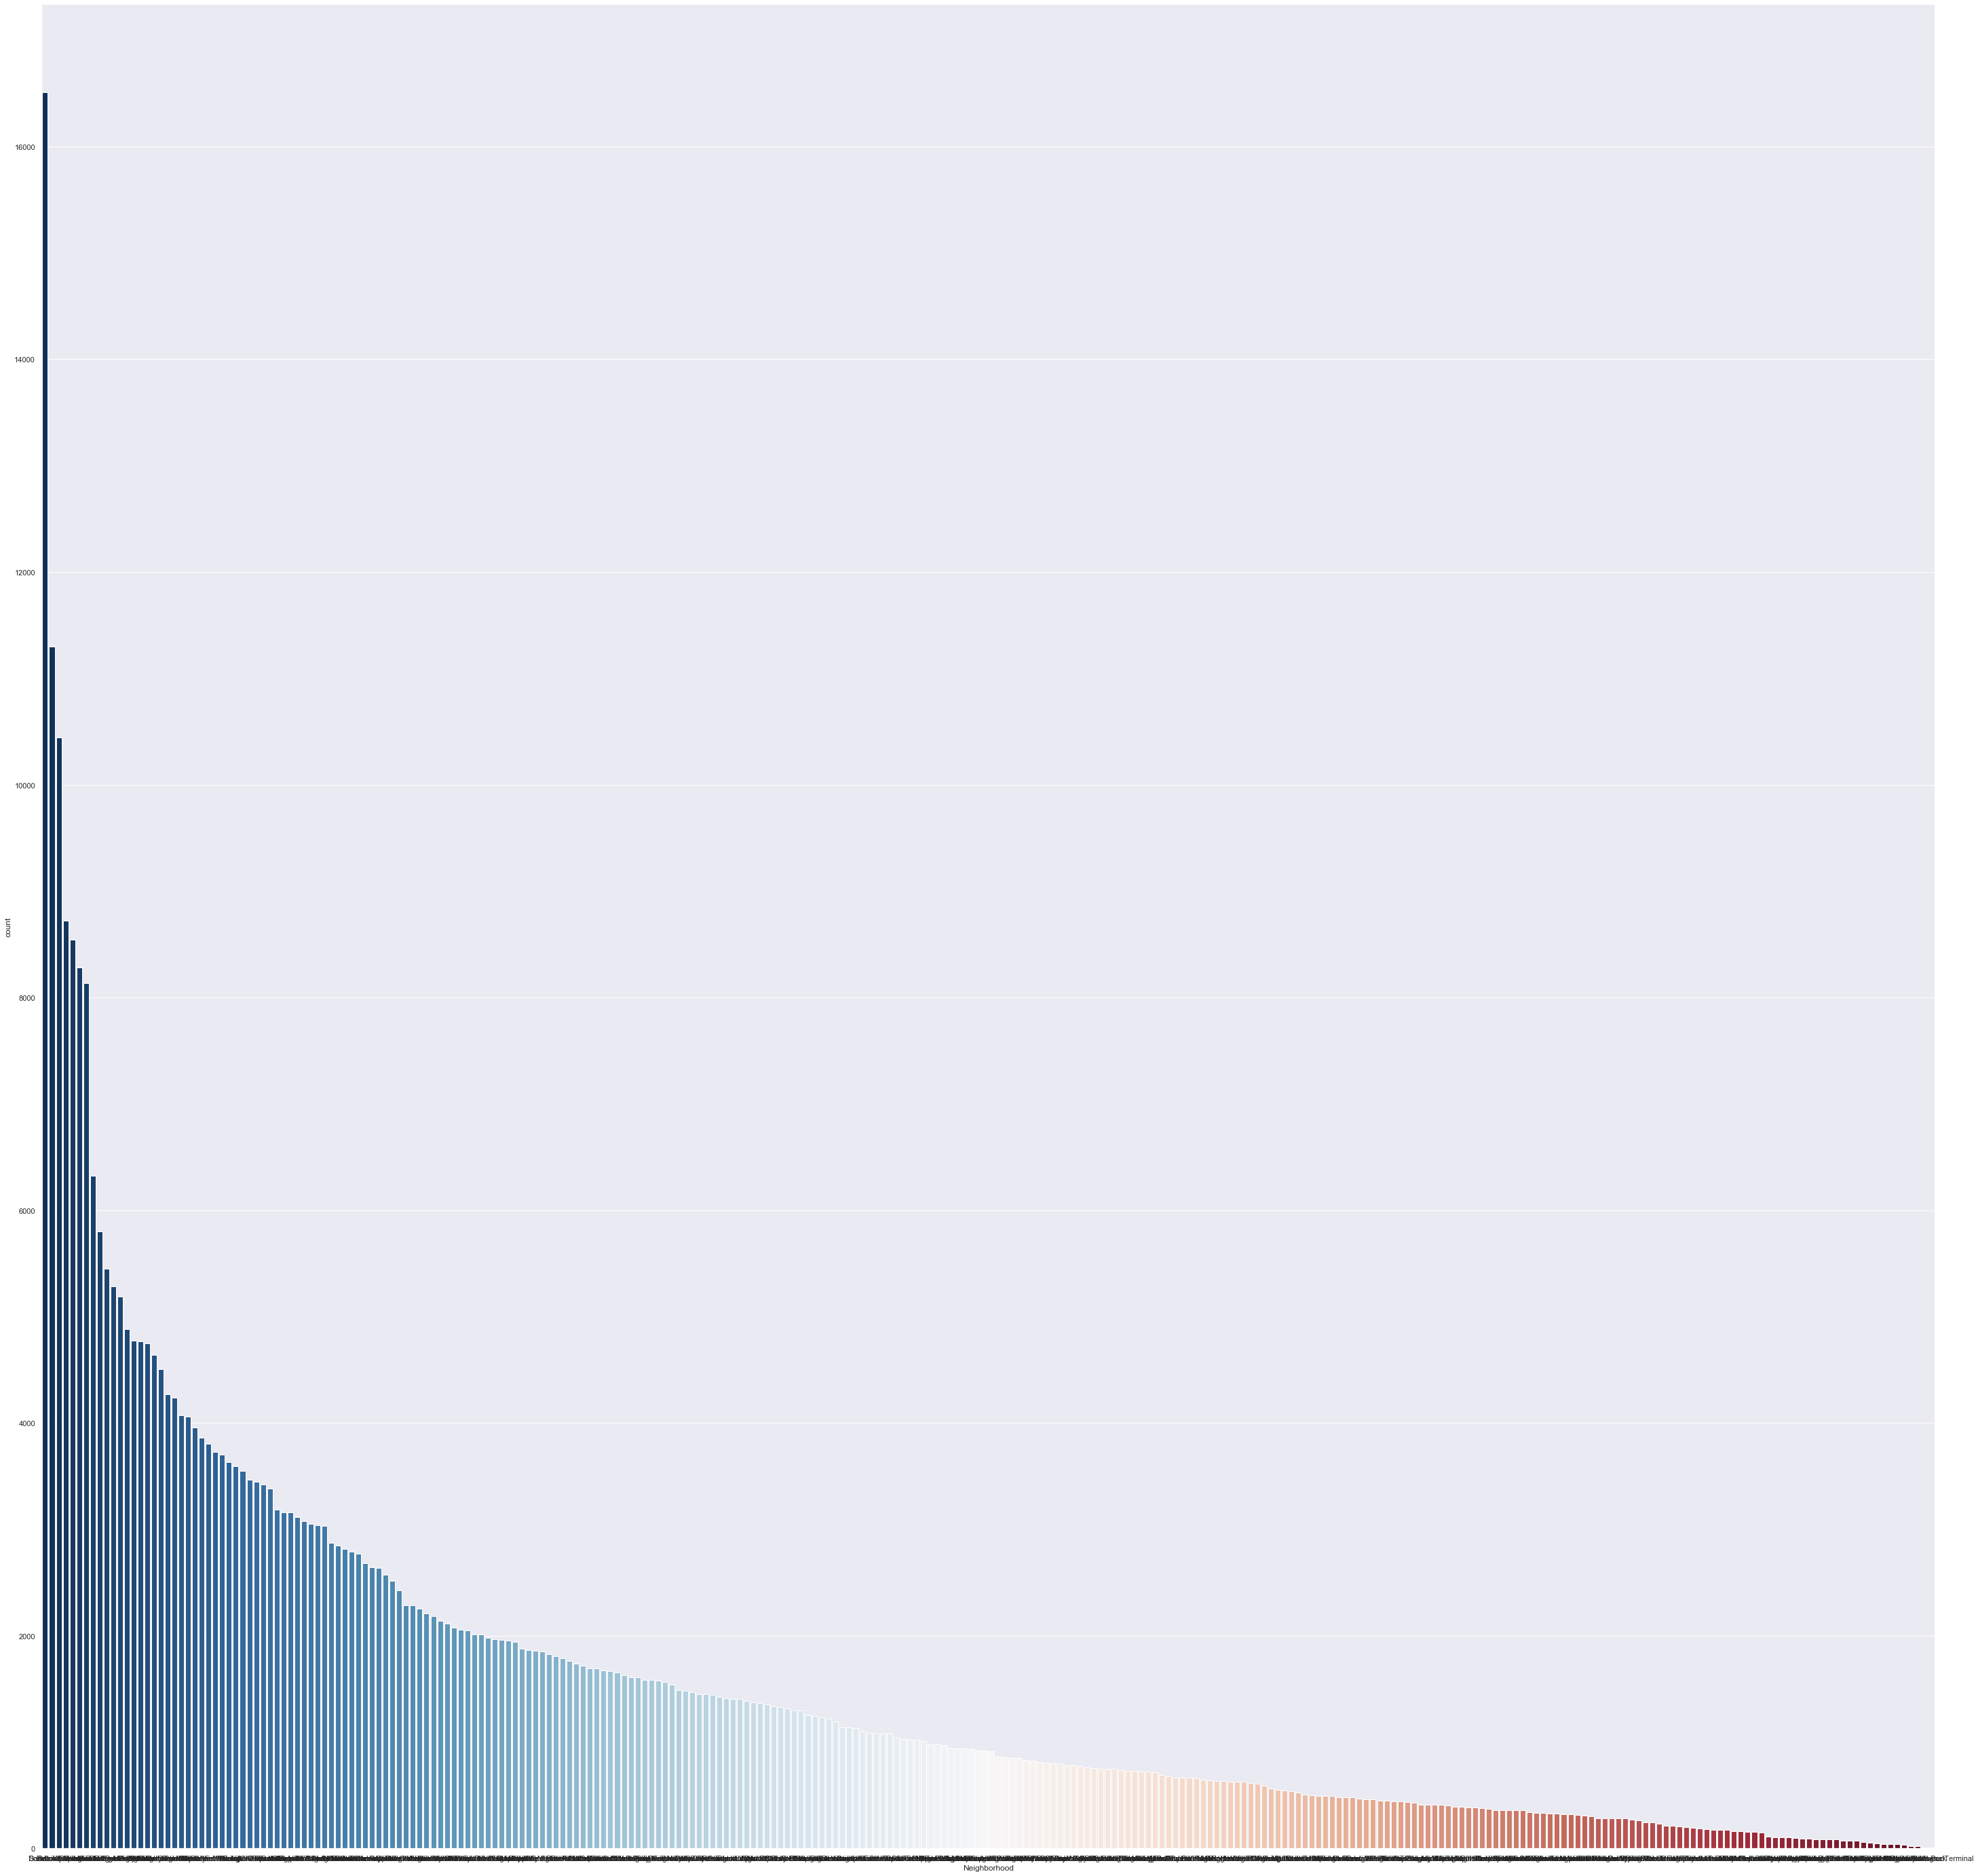

In [13]:
# Neighborhoood distribution
sns.set(style="darkgrid")
plt.figure(figsize=(50,50))
sns.countplot(x="Neighborhood", data=call_data,palette="RdBu_r", order = call_data['Neighborhood'].value_counts().index)

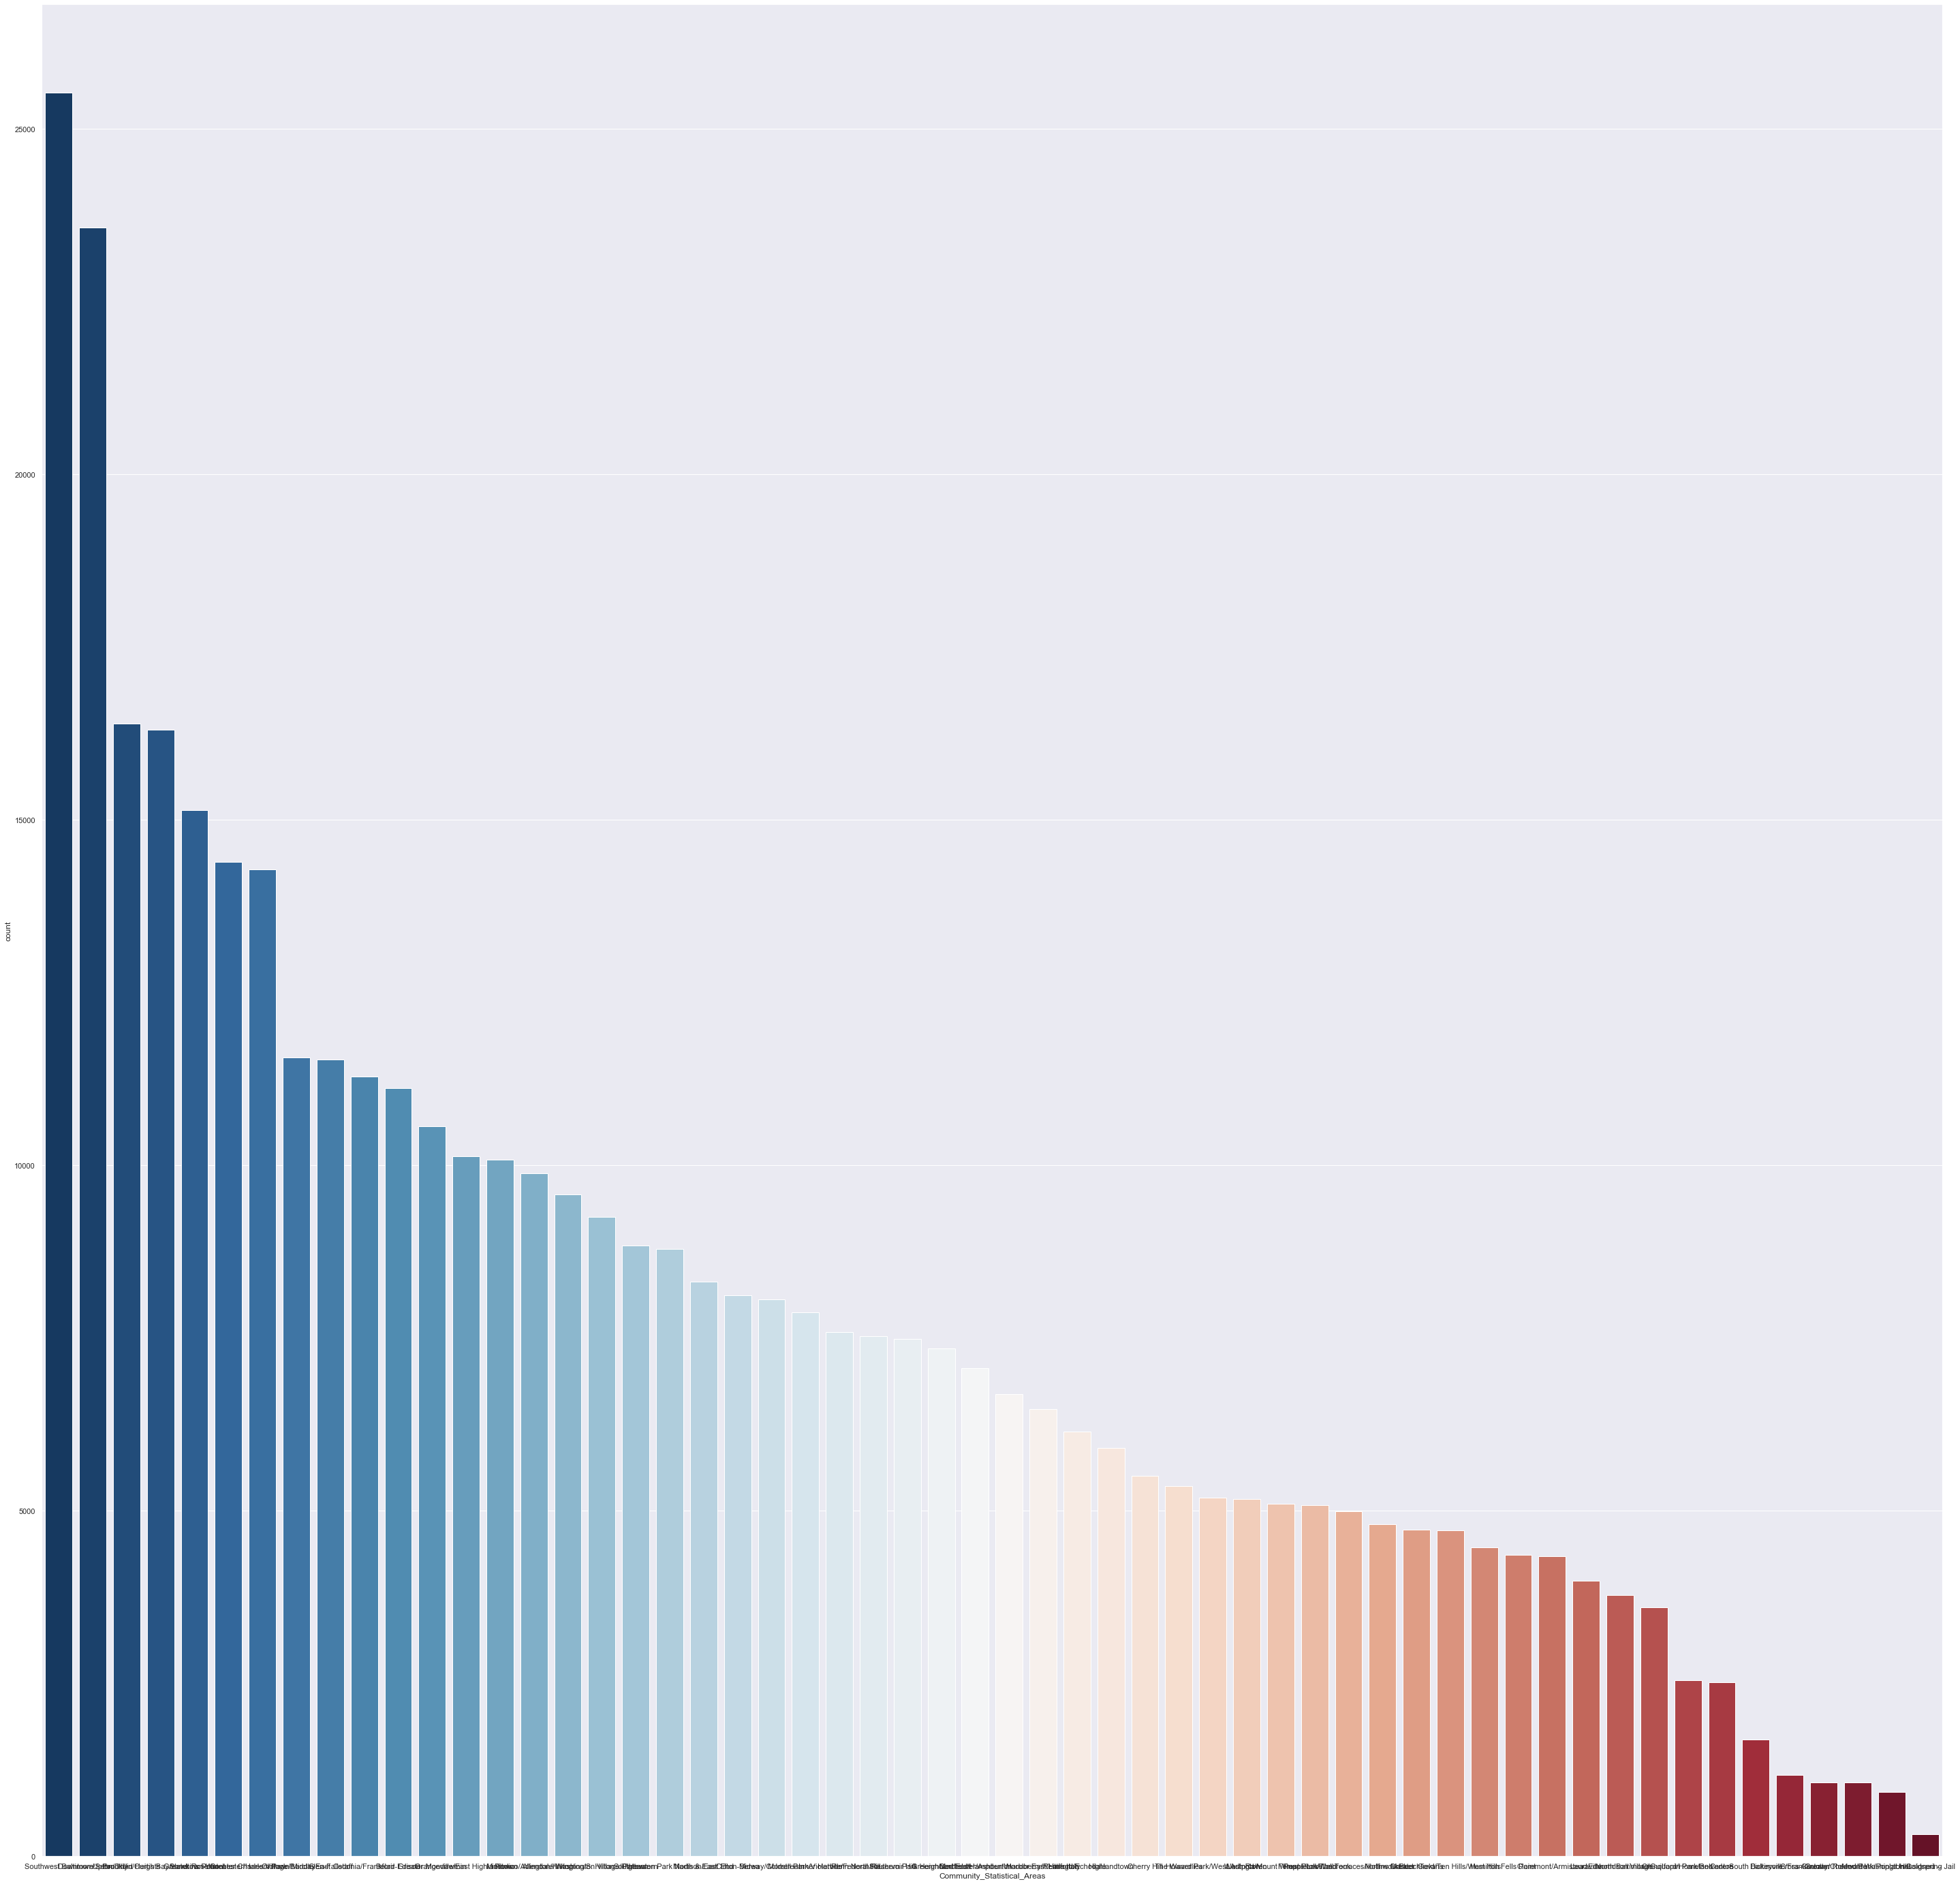

In [14]:
# CSA distribution
sns.set(style="darkgrid")
plt.figure(figsize=(50,50))
sns.countplot(x="Community_Statistical_Areas", data=call_data,palette="RdBu_r", order = call_data['Community_Statistical_Areas'].value_counts().index)

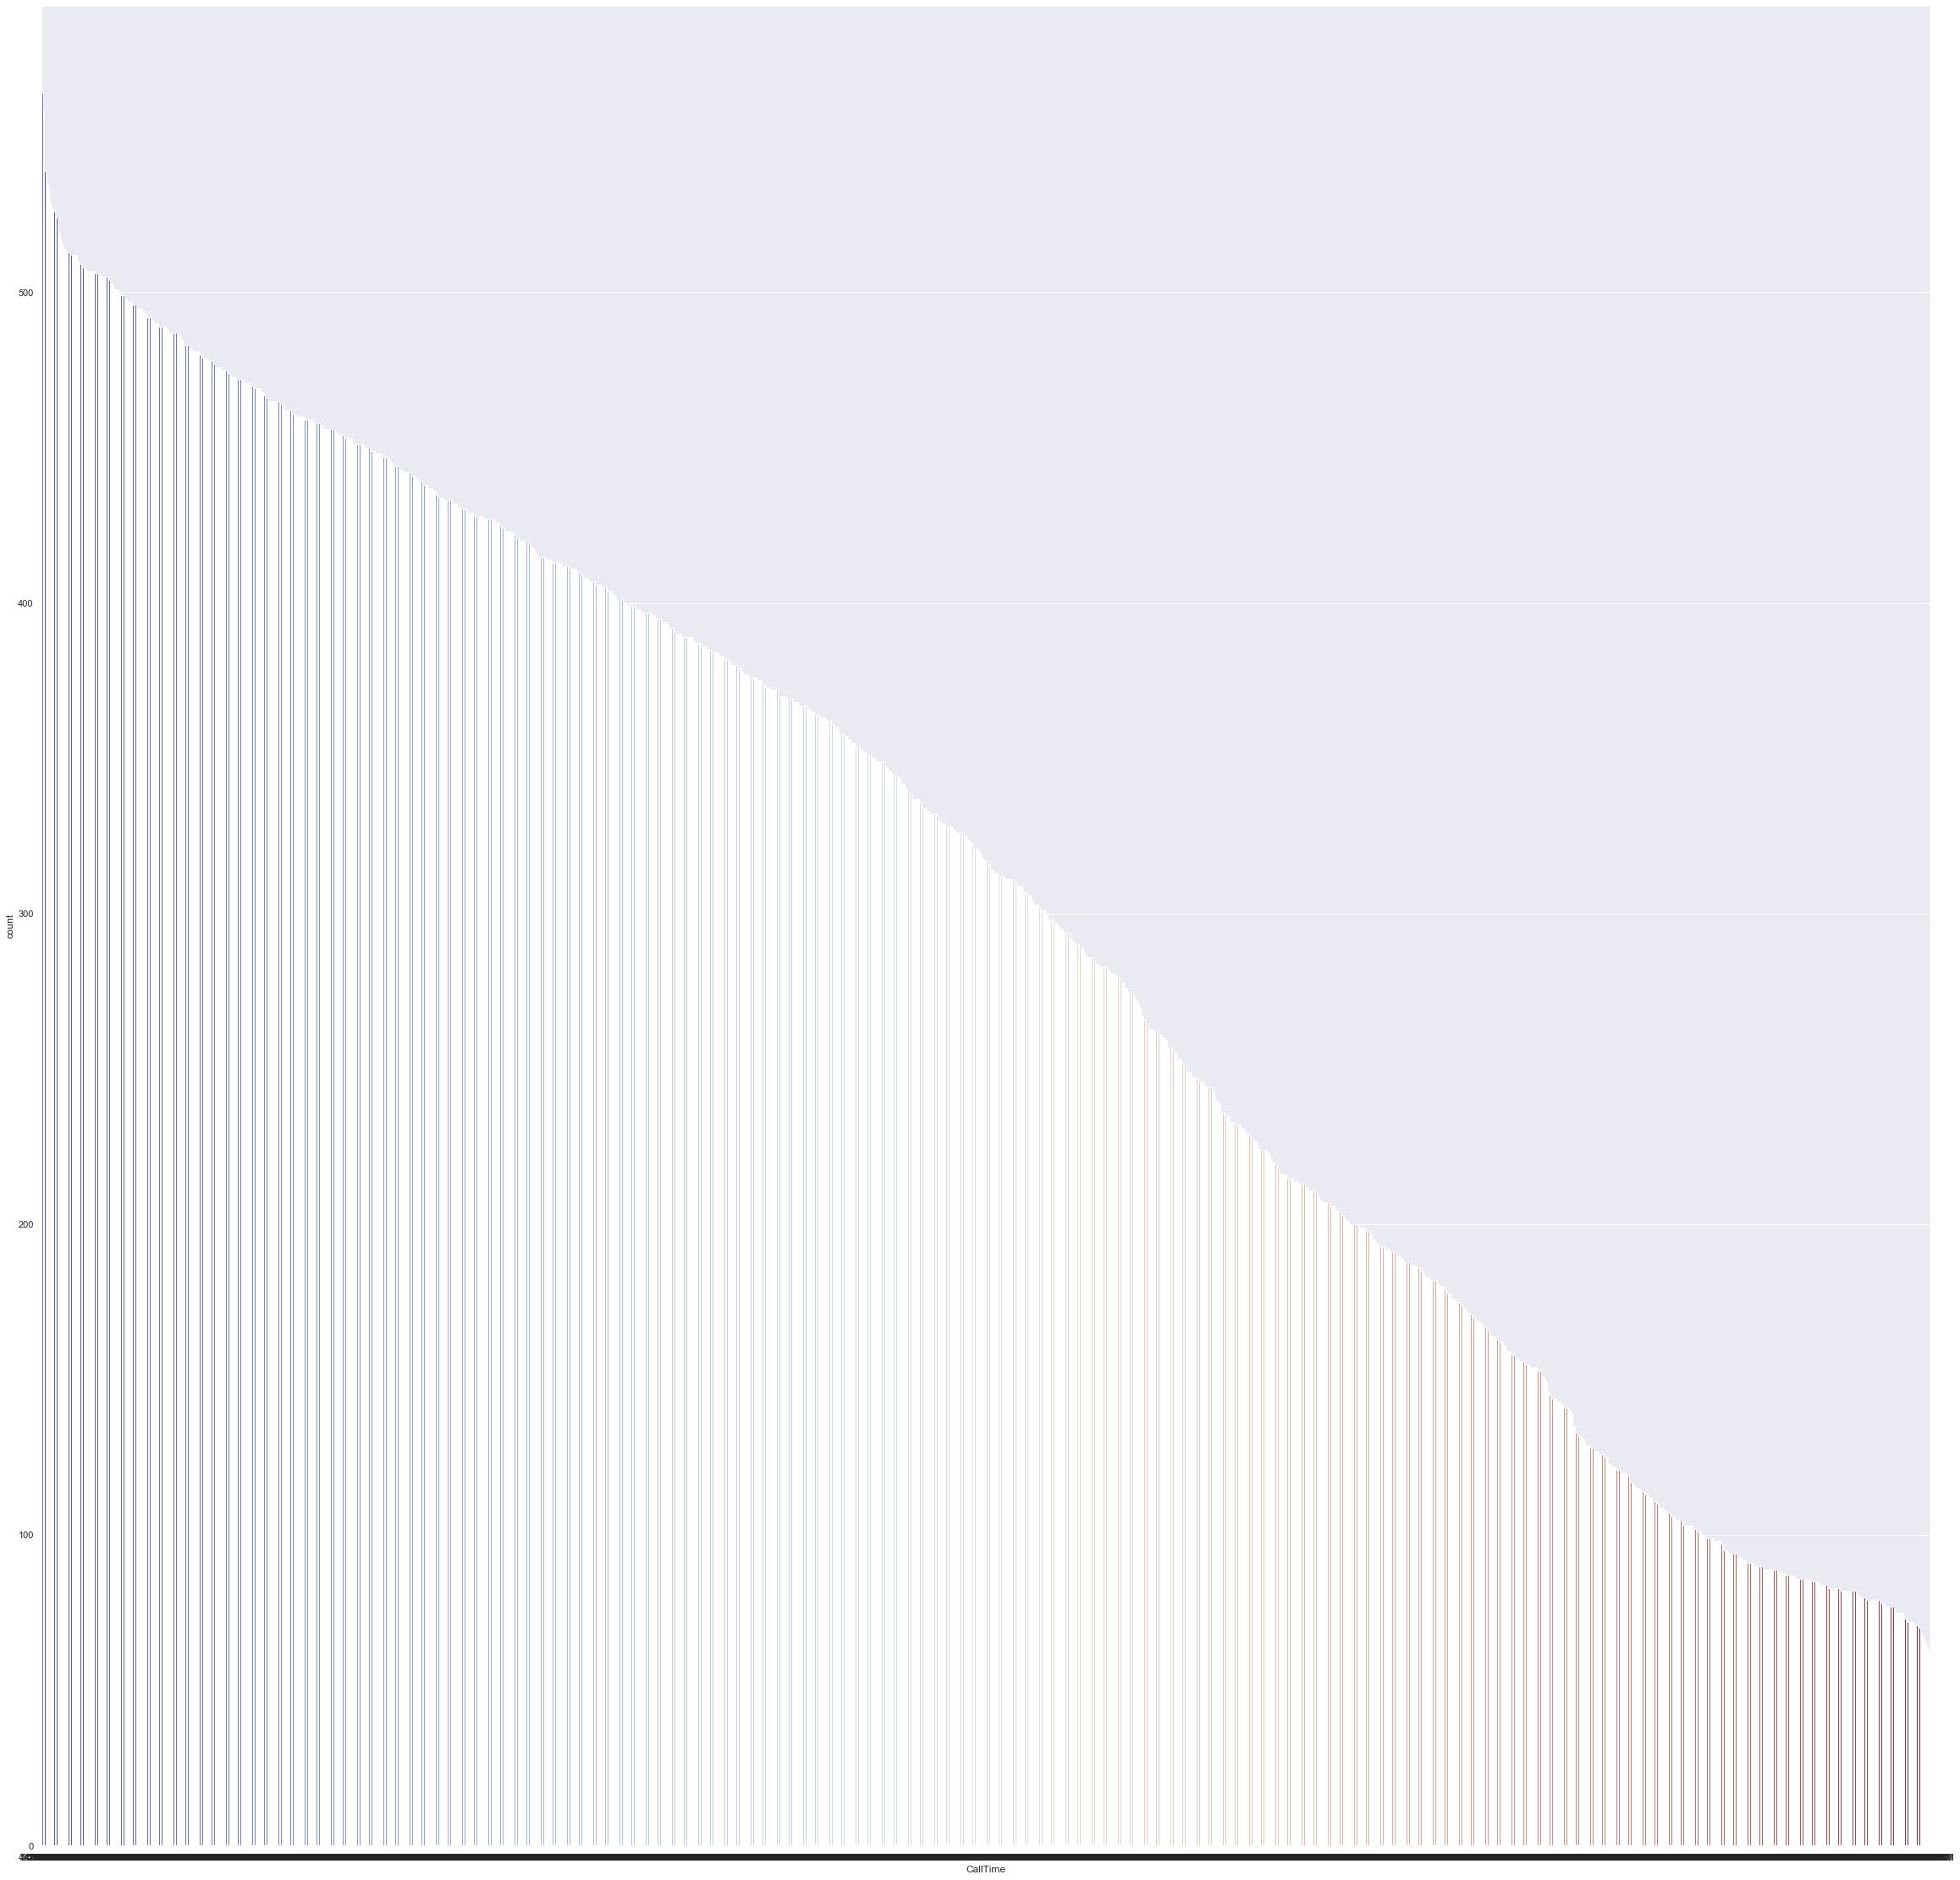

In [15]:
# CallTime distribution
sns.set(style="darkgrid")
plt.figure(figsize=(40,40))
sns.countplot(x="CallTime", data=call_data, palette="coolwarm", order = call_data['CallTime'].value_counts().index)

<Figure size 2880x2160 with 0 Axes>

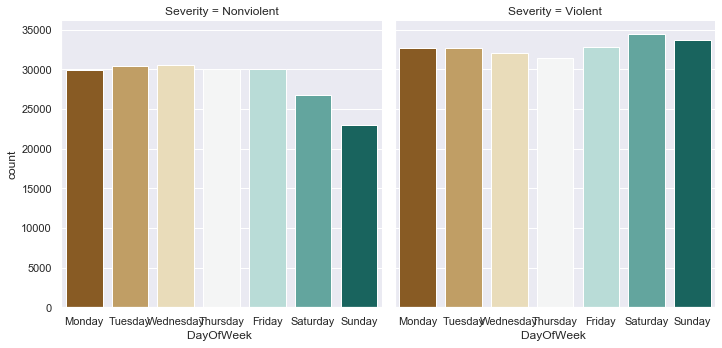

In [16]:
# DayOfWeek distribution
sns.set(style="darkgrid")
plt.figure(figsize=(40,30))
sns.catplot("DayOfWeek ", col="Severity", data=call_data, palette="BrBG", kind="count", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);

# Classification w/ Logistic Regression¶

In [325]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


def load_vars(file): 
    
    # Split data into X (predictor variable) and y (target variable). Using .values to retrieve numpy array
    X = call_data["Neighborhood"].values
    y = call_data["Severity"].values

    # Format fields in predictor variable as string
    X = X.astype(str)
    # Reshape target variable to be 2d arrray (one column)
    y = y.reshape((len(y),1))
    return X, y

# Call our X and y variables
X, y = load_vars(call_data)


# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
# Verifying train/test shape
print('Train data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)


# Standardize training data
def standardize(X_train, X_test): 
    
    #Fit only to training data 
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test



# Encoding predictor variable 
def encode_predictor(X_train, X_test): 
    
    # Best practice: Fit encoding on training data, then apply it to train and test set
    ohe = OneHotEncoder()
    X_train = X_train.reshape(-1,1) #For some reason, if I don't reshape here, I get an error. Why? 
    ohe.fit(X_train)
    X_train_enc = ohe.transform(X_train)
    X_test = X_train.reshape(-1,1)  #For some reason, if I don't reshape here, I get an error. Why? 
    X_test_enc = ohe.transform(X_test)
    return X_train_enc, X_test_enc



# Encoding target variable 
def encode_target(y_train, t_test): 
    
    ohe = OneHotEncoder()
    ohe.fit(y_train)
    y_train_enc = ohe.transform(y_train)
    y_test_enc = ohe.transform(y_test)
    return y_train_enc, y_test_enc


# Transform predictor variable
X_train_enc, X_test_enc = encode_predictor(X_train, X_test)

# Transform target variable
y_train_enc, y_test_enc = encode_target(y_train, y_test)

print('\nOne Hot Encoded Train data:', X_train_enc.shape, y_train_enc.shape)
print('One Hot Encoded Test data:', X_test_enc.shape, y_test_enc.shape)




Train data: (344204,) (344204, 1)
Test data: (86051,) (86051, 1)

One Hot Encoded Train data: (344204, 279) (344204, 2)
One Hot Encoded Test data: (344204, 279) (86051, 2)


In [326]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression()

In [327]:
X_train_enc.shape

(344204, 279)

In [320]:
y_train_enc.shape

(344204, 2)

### Remove all hashtags from the cell below. This is where the error happens. 
Passing our newly one-hot encoded variables resullts in a bad input shape error. Why? 

* Is X_train_enc and y_train_enc supposed to be the same shape? 
* X_train_enc.shape makes sense. We have 279 different neighborhoods so with one-hot encoding a column for each neighborhood is expected. 
* y_train_enc.shape is telling us that there are 344204 rows and 2 columns. We have 2 possible classes for our target variable (i.e Severity), which includes Non-violent (0) and Violent (1). I feel like the problem is with the shape of this variable but **aren't two columns expected here?**

In [337]:
#logreg.fit(X_train_enc, y_train_enc)
#logreg_pred = logreg.predict(X_test_enc)
#logreg
